# Research - Soha Yusuf (RIN: 662011092)

# Graph Neural Network to solve Au=b

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import AddSelfLoops
from torch_geometric.data import Data, DataLoader

from scipy.sparse import coo_matrix, csr_matrix
from torch_sparse import coalesce, SparseTensor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

C:\Users\soha9\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load sparse matrix A in coo format

A:   m x n  

b:   n x 1

x:   m x 1

In [3]:
#Load the data
A_matrix_path = "data/A_ex9.txt"
A_info = np.loadtxt(A_matrix_path)

# Extract the row, column, and value arrays from the data
row_A = A_info[:, 0].astype(int)
col_A = A_info[:, 1].astype(int)
val_A = A_info[:, 2]

# Create the sparse matrix using COO format
A = coo_matrix((val_A, (row_A, col_A)))
num_nodes = A.shape[0]

print('Number of nodes: ', num_nodes)
print('A shape: ', A.shape)

Number of nodes:  36865
A shape:  (36865, 36865)


## Load u

In [4]:
# # Load u
# u_vector_path = "data/u_ex9.txt"
# u = np.loadtxt(u_vector_path)
# print('u shape: ', u.shape)

## Compute b

In [5]:
# Convert A to PyTorch SparseTensor
indices = torch.from_numpy(np.vstack((A.row, A.col))).long()
values = torch.from_numpy(A.data).float()
shape = torch.Size(A.shape)
A = torch.sparse.FloatTensor(indices, values, shape)

u = torch.FloatTensor(np.random.rand(num_nodes, 1))
b = A.matmul(u)

print(b.shape)
print(u.shape)
print(A.shape)

torch.Size([36865, 1])
torch.Size([36865, 1])
torch.Size([36865, 36865])


In [6]:
A

tensor(indices=tensor([[    1,     1,     1,  ..., 36864, 36864, 36864],
                       [    1,     2,     3,  ..., 36862, 36863, 36864]]),
       values=tensor([ 8.8577e-06,  3.3011e-06, -3.3011e-06,  ...,
                      -3.3005e-06,  3.2999e-06,  8.8583e-06]),
       size=(36865, 36865), nnz=662016, layout=torch.sparse_coo)

In [7]:
u

tensor([[0.6212],
        [0.1044],
        [0.0266],
        ...,
        [0.1812],
        [0.3843],
        [0.7157]])

In [8]:
b

tensor([[ 0.0000e+00],
        [-1.5544e-06],
        [-5.1648e-06],
        ...,
        [ 5.9315e-06],
        [ 1.0078e-05],
        [ 1.1225e-05]])

## Edge Index

In graph neural networks, edge_index is a commonly used term that refers to a matrix or tensor that represents the edges of a graph. It is a two-dimensional matrix with two rows, where each column represents an edge of the graph. The first row of the matrix contains the index of the source nodes of each edge, while the second row contains the index of the destination nodes.

For example, let's say we have a simple undirected graph with 4 nodes and 3 edges, where the edges are (0,1), (1,2), and (2,3). We can represent this graph using the following edge_index matrix:

```
edge_index = [
  [0, 1, 1, 2],
  [1, 0, 2, 3]
]
```
Here, the first row of edge_index represents the source nodes of each edge, and the second row represents the destination nodes. For example, the first edge (0,1) has source node 0 and destination node 1.

The edge_index matrix is typically used in conjunction with node feature matrices to define the input to a graph neural network. The node feature matrix contains features for each node in the graph, while the edge_index matrix describes the edges that connect the nodes. By combining these two matrices, a graph neural network can learn to operate on the graph structure and its associated features.

## Edge Weights

In graph neural networks, edge_weights are values associated with the edges of a graph, which can be used to represent the strength, importance or similarity between connected nodes. edge_weights can be used in a variety of ways, such as during message passing, graph convolutions or pooling operations.

edge_weights can be represented as a tensor or an array, with one value per edge. If the edges are unweighted, i.e., all edges are equally important, then the edge_weights can be represented as an array of ones. However, if the edges have different weights, then the edge_weights can be assigned accordingly.

In [9]:
# Assuming A_sp is a PyTorch SparseTensor
A_coo = A.coalesce()
edge_index = A_coo.indices()
edge_weights = A_coo.values()

# Convert edge indices to PyTorch LongTensor
edge_index = edge_index.long()

In [10]:
print('====== Edge Index =====')
print('edge_index shape: ',edge_index.shape)
print(edge_index)
print('====== Edge Weights =====')
print('edge_weights shape: ',edge_weights.shape)
print(edge_weights)

====== Edge Index =====
edge_index shape:  torch.Size([2, 662016])
tensor([[    1,     1,     1,  ..., 36864, 36864, 36864],
        [    1,     2,     3,  ..., 36862, 36863, 36864]])
====== Edge Weights =====
edge_weights shape:  torch.Size([662016])
tensor([ 8.8577e-06,  3.3011e-06, -3.3011e-06,  ..., -3.3005e-06,
         3.2999e-06,  8.8583e-06])


## Create data object for input to GNN

The Data object has the following attributes:

- **'x'**: a tensor of node features with shape **'[36865, 1]'**. This means there are 36865 nodes in the graph, each with 1 feature.
- **'edge_index'**: a tensor of shape **'[2, 662016]'** representing the edge index of the graph. The first row contains the source nodes and the second row contains the destination nodes. There are 662016 edges in the graph.

- **'edge_attr'**: a tensor of edge weights with shape **'[662016]'**. This means there is one weight for each edge in the graph.

- **'num_nodes'**: an integer value of **36865** representing the total number of nodes in the graph.

In [12]:
# Create a Data object from edge_index, edge_weights, and node features
data = Data(x=b, edge_index=edge_index, edge_attr=edge_weights, num_nodes=num_nodes, y=u)
data = data.to(device)

# Print the Data object
print(data)

Data(x=[36865, 1], edge_index=[2, 662016], edge_attr=[662016], y=[36865, 1], num_nodes=36865)


## Graph Neural Network model

The given model is a graph convolutional network (GCN) that consists of 4 graph convolutional layers.

- First layer, the model takes a feature vector of size 1 for each node and applies the GCNConv operation with 128 output channels. The output of this layer is then passed through a rectified linear unit (ReLU) activation function.

- Last layer applies the GCNConv operation with a single output channel, which is the predicted value for each node.

The model takes the input data **'x'** and **'edge_index'** and returns the predicted values for each node.

In [13]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 16)
        self.conv4 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        return x

## Train Graph Convolutional Network

In [14]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the training loop
def train(model, data, optimizer, criterion, device):
    model.train()

    # Move the data to the device
    data = data.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Compute the model output
    out = model(data.x, data.edge_index)

    # Compute the loss
    loss = criterion(out, data.y)

    # Backpropagate the gradients
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
loss_list = []
for epoch in range(500):
    loss = train(model, data, optimizer, criterion, device)
    loss_list.append(loss)
    print('Epoch {}, Loss: {}'.format(epoch, loss))

Epoch 0, Loss: 0.33187273144721985
Epoch 1, Loss: 0.30477696657180786
Epoch 2, Loss: 0.2590939402580261
Epoch 3, Loss: 0.20694494247436523
Epoch 4, Loss: 0.15360644459724426
Epoch 5, Loss: 0.10746609419584274
Epoch 6, Loss: 0.08469660580158234
Epoch 7, Loss: 0.10403674095869064
Epoch 8, Loss: 0.1315341591835022
Epoch 9, Loss: 0.12863460183143616
Epoch 10, Loss: 0.11013840138912201
Epoch 11, Loss: 0.09360350668430328
Epoch 12, Loss: 0.08555099368095398
Epoch 13, Loss: 0.08482202142477036
Epoch 14, Loss: 0.08791176229715347
Epoch 15, Loss: 0.09188555181026459
Epoch 16, Loss: 0.09504906833171844
Epoch 17, Loss: 0.09656891226768494
Epoch 18, Loss: 0.0964377298951149
Epoch 19, Loss: 0.09492002427577972
Epoch 20, Loss: 0.09245795756578445
Epoch 21, Loss: 0.08960243314504623
Epoch 22, Loss: 0.08695004880428314
Epoch 23, Loss: 0.08506283909082413
Epoch 24, Loss: 0.08435223251581192
Epoch 25, Loss: 0.0848984569311142
Epoch 26, Loss: 0.0861714631319046
Epoch 27, Loss: 0.08729904145002365
Epoch 2

Epoch 228, Loss: 0.08415057510137558
Epoch 229, Loss: 0.08414970338344574
Epoch 230, Loss: 0.0841488391160965
Epoch 231, Loss: 0.08414797484874725
Epoch 232, Loss: 0.08414710313081741
Epoch 233, Loss: 0.08414623141288757
Epoch 234, Loss: 0.08414535224437714
Epoch 235, Loss: 0.08414449542760849
Epoch 236, Loss: 0.08414360880851746
Epoch 237, Loss: 0.08414273709058762
Epoch 238, Loss: 0.08414185792207718
Epoch 239, Loss: 0.08414098620414734
Epoch 240, Loss: 0.0841401070356369
Epoch 241, Loss: 0.08413922786712646
Epoch 242, Loss: 0.08413835614919662
Epoch 243, Loss: 0.08413747698068619
Epoch 244, Loss: 0.08413658291101456
Epoch 245, Loss: 0.08413571119308472
Epoch 246, Loss: 0.08413482457399368
Epoch 247, Loss: 0.08413394540548325
Epoch 248, Loss: 0.08413305878639221
Epoch 249, Loss: 0.08413217216730118
Epoch 250, Loss: 0.08413128554821014
Epoch 251, Loss: 0.08413039892911911
Epoch 252, Loss: 0.08412951231002808
Epoch 253, Loss: 0.08412862569093704
Epoch 254, Loss: 0.08412773907184601
Epo

Epoch 451, Loss: 0.08394666761159897
Epoch 452, Loss: 0.08394575864076614
Epoch 453, Loss: 0.08394484966993332
Epoch 454, Loss: 0.0839439406991005
Epoch 455, Loss: 0.08394303172826767
Epoch 456, Loss: 0.08394213020801544
Epoch 457, Loss: 0.08394122123718262
Epoch 458, Loss: 0.08394031226634979
Epoch 459, Loss: 0.08393940329551697
Epoch 460, Loss: 0.08393850177526474
Epoch 461, Loss: 0.08393760770559311
Epoch 462, Loss: 0.08393669873476028
Epoch 463, Loss: 0.08393578976392746
Epoch 464, Loss: 0.08393488079309464
Epoch 465, Loss: 0.083933986723423
Epoch 466, Loss: 0.08393307775259018
Epoch 467, Loss: 0.08393218368291855
Epoch 468, Loss: 0.08393127471208572
Epoch 469, Loss: 0.08393038064241409
Epoch 470, Loss: 0.08392947912216187
Epoch 471, Loss: 0.08392858505249023
Epoch 472, Loss: 0.083927683532238
Epoch 473, Loss: 0.08392678201198578
Epoch 474, Loss: 0.08392588049173355
Epoch 475, Loss: 0.08392497897148132
Epoch 476, Loss: 0.08392408490180969
Epoch 477, Loss: 0.08392319083213806
Epoch 

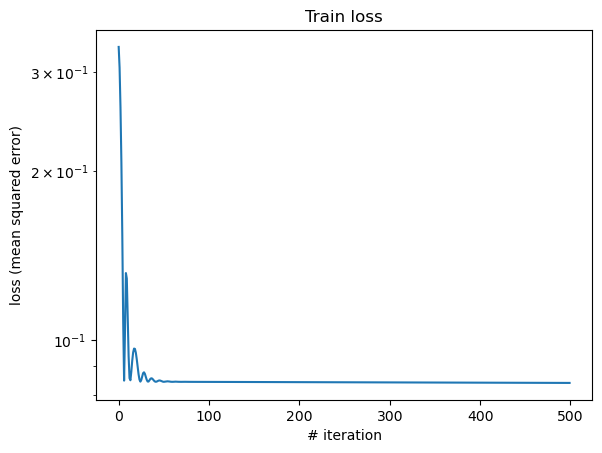

In [15]:
plt.figure(1)
plt.plot(loss_list, label = 'train loss')
plt.xlabel('# iteration')
plt.ylabel('loss (mean squared error)')
plt.yscale('log')
plt.title('Train loss')
plt.show()

In [16]:
data.edge_index

tensor([[    1,     1,     1,  ..., 36864, 36864, 36864],
        [    1,     2,     3,  ..., 36862, 36863, 36864]], device='cuda:0')

In [17]:
# Compute predicted u and residual error
model.eval()
predicted_u = model(data.x, data.edge_index)

In [18]:
predicted_u

tensor([[0.4953],
        [0.4888],
        [0.4888],
        ...,
        [0.4827],
        [0.4827],
        [0.5119]], device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
u

tensor([[0.6212],
        [0.1044],
        [0.0266],
        ...,
        [0.1812],
        [0.3843],
        [0.7157]])

# Residual Error 

The residual error can be interpreted as the sum of the squared distances between the predicted values Au and the true values b. It is a measure of how well the solution u fits the original matrix equation Au = b. A lower residual error indicates a better fit of the solution to the equation.

\begin{equation}
error = \sum(||Au - b||^{2})
\end{equation}

In [20]:
residual = (torch.mm(A.to(device), predicted_u) - b.to(device))
residual

tensor([[ 0.0000e+00],
        [ 7.4996e-06],
        [ 3.4891e-05],
        ...,
        [ 2.3305e-05],
        [ 1.9381e-05],
        [-5.0572e-06]], device='cuda:0', grad_fn=<SubBackward0>)

In [21]:
residual_error = torch.sum(torch.square(torch.mm(A.to(device), predicted_u) - b.to(device)))
print(f'Residual error is: {residual_error}')

Residual error is: 4.600614192895591e-05
